BloomTech Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets

- Continue to clean and explore your data. 
- For the evaluation metric you chose, what score would you get just by guessing?
- Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

## Business Scenario

Lending Club is an American peer-to-peer lending marketplace that connects investors with borrowers. Instead of a bank or financial institution, investors act as lenders to fund borrowers loans.

Investors want to lend money to people who show a profile 
of having a high probability of repayment. However, they face the challenge of predicting the risk of a borrower being unable to pay the loan back in full. They feel that the insights from existing data will help them in making data-driven decisions. So as data scientists, we will be building a model that can help in predicting whether a loan will not be repaid.

The dataset contains more than 9,500 loans with information about the borrower profile, loan structure and whether the loan was repaid. This data was extracted from [Kaggle - Loan Data](https://www.kaggle.com/datasets/itssuru/loan-data). 

### Data dictionary

|    | Variable          | Explanation                                                                                                             |
|---:|:------------------|:------------------------------------------------------------------------------------------------------------------------|
|  0 | credit_policy     | 1 if the customer meets the credit underwriting criteria; 0 otherwise.                                                  |
|  1 | purpose           | The purpose of the loan.                                                                                                |
|  2 | int_rate          | The interest rate of the loan (more risky borrowers are assigned higher interest rates).                                |
|  3 | installment       | The monthly installments owed by the borrower if the loan is funded.                                                    |
|  4 | log_annual_inc    | The natural log of the self-reported annual income of the borrower.                                                     |
|  5 | dti               | The debt-to-income ratio of the borrower (amount of debt divided by annual income).                                     |
|  6 | fico              | The FICO credit score of the borrower.                                                                                  |
|  7 | days_with_cr_line | The number of days the borrower has had a credit line.                                                                  |
|  8 | revol_bal         | The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).                           |
|  9 | revol_util        | The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available). |
| 10 | inq_last_6mths    | The borrower's number of inquiries by creditors in the last 6 months.                                                   |
| 11 | delinq_2yrs       | The number of times the borrower had been 30+ days past due on a payment in the past 2 years.                           |
| 12 | pub_rec           | The borrower's number of derogatory public records.                                                                     |
| 13 | not_fully_paid    | 1 if the loan is not fully paid; 0 otherwise.   

In [1]:
# Import Libraries, Dataset

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from category_encoders import OrdinalEncoder, OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTENC # to fix imbalance data
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.ensemble import RandomForestClassifier

# Path to dataset
DATA_PATH = '/Users/Yanin/Documents/BloomTech/Course/Sprint7/datasets/loan_data.csv'

## I. Wrangle Data

In [2]:
def wrangle(filepath):
    loans = pd.read_csv(filepath)
    
    # Replacing period in column names with underscore
    loans.columns = loans.columns.str.replace(".", "_")
    
    # Set data type of 'purpose' column as category
    loans['purpose'] = loans['purpose'].astype('category')
    
    # Outliers - Finding the upper and lower bounds for the log_annual_inc feature
    def find_outlier_limits(col_name):
        Q1,Q3=loans[col_name].quantile([.25,.75])
        IQR=Q3-Q1
        low=Q1-(1.5* IQR)
        high=Q3+(1.5* IQR)
        return (high,low)

    high_log_annual_inc, low_log_annual_inc = find_outlier_limits('log_annual_inc')

    # Replacing outlier values for log_annual_inc, and installment with respective upper and lower limits 
    loans.loc[loans['log_annual_inc'] > high_log_annual_inc,'log_annual_inc'] = high_log_annual_inc
    loans.loc[loans['log_annual_inc'] < low_log_annual_inc,'log_annual_inc'] = low_log_annual_inc
    
    return loans

In [3]:
# Read loans data
loans = wrangle(DATA_PATH)

# Check shape of data set and first 5 rows
display(loans.shape)
loans.head()

/var/folders/tj/1shzq07s7nq_rmtc7c_gkztm0000gp/T/ipykernel_6432/2312075822.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  loans.columns = loans.columns.str.replace(".", "_")


(9578, 14)

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


Your code starts here:

In [4]:
# Get Pandas Profiling Report
ProfileReport(loans, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Exploratory Data Analysis

In [5]:
# Get value counts of credit_policy
# How many loans were extended to borrowers who did not meet the underwriting criteria?
loans['credit_policy'].value_counts()

1    7710
0    1868
Name: credit_policy, dtype: int64

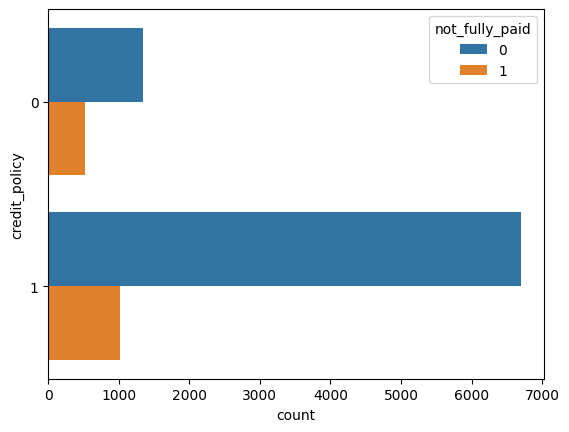

In [6]:
# From borrowers who didn't meet the underwriting criteria, how many were defaulters?
sns.countplot(data=loans, y='credit_policy', hue='not_fully_paid');

In [7]:
# Count of defaulters per credit_policy 
loans.groupby(['credit_policy', 'not_fully_paid'])['not_fully_paid'].count()

credit_policy  not_fully_paid
0              0                 1349
               1                  519
1              0                 6696
               1                 1014
Name: not_fully_paid, dtype: int64

In [8]:
# Percentage of defaulters per credit_policy 
loans.groupby('credit_policy')['not_fully_paid'].value_counts(normalize=True)

credit_policy  not_fully_paid
0              0                 0.722163
               1                 0.277837
1              0                 0.868482
               1                 0.131518
Name: not_fully_paid, dtype: float64

In [9]:
# How many times was fico > 800 in the dataset
excel_fico_count = len([i for i in loans['fico'] if i > 800])

# Percentage of borrowers with excellent scores
excel_fico_pt = (excel_fico_count/len(loans)) * 100
print('% of borrowers with excellent credit score:', round(excel_fico_pt, 2))

% of borrowers with excellent credit score: 1.51


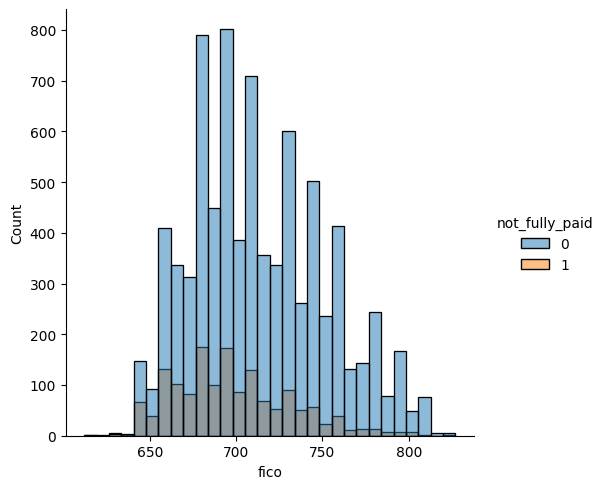

In [10]:
# Fico distributions per loan payment outcome 
sns.displot(data=loans, x='fico', bins = 30, hue = 'not_fully_paid', legend=True);

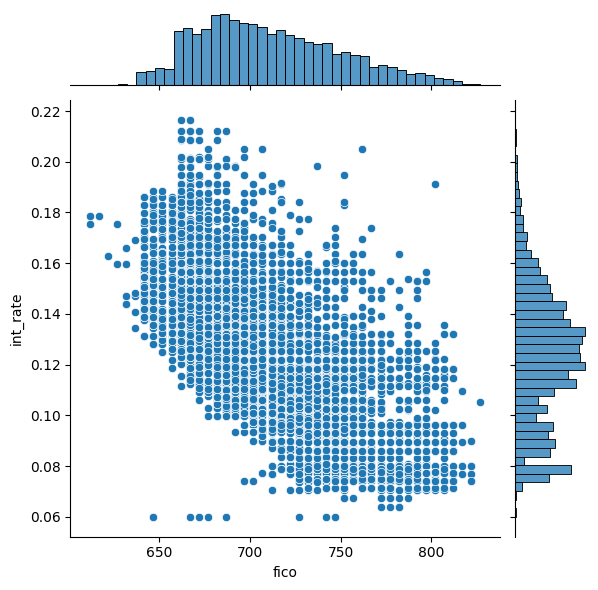

In [11]:
# Visualize trend between fico and interest rate
sns.jointplot(x = 'fico', y = 'int_rate', data = loans);

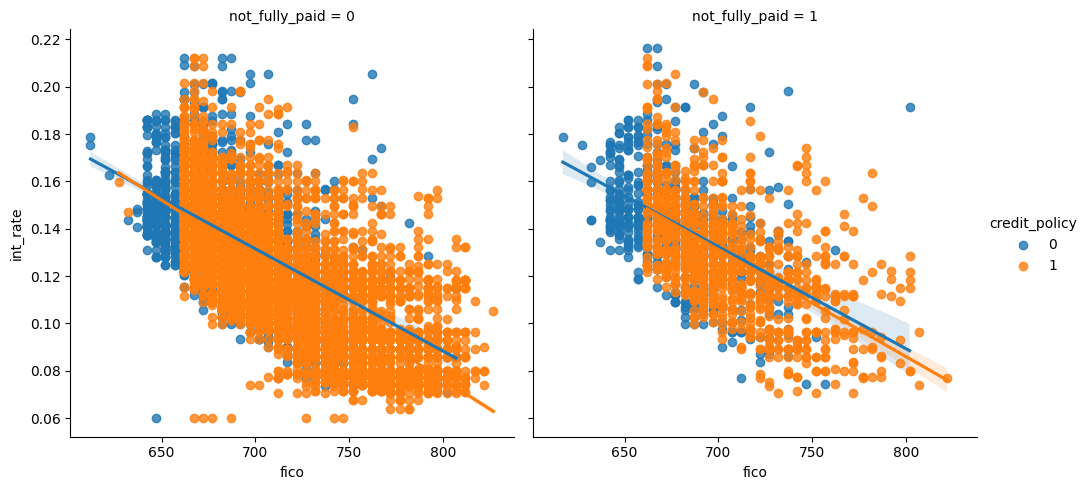

In [12]:
# Relationship between fico and int rate based on if the loan was paid in full or not - grouped by credit policy 
sns.lmplot(data= loans, x = 'fico', y = 'int_rate', col = 'not_fully_paid', hue = 'credit_policy');

### Feature Engineering

1. The minimum credit score needed for a Lending Club loan is 600. However, investors/lenders prefer to extend credit to borrowers with good or excellent credit scores.

|    | Variable          | Explanation                                                                                                             |
|---:|:------------------|:------------------------------------------------------------------------------------------------------------------------|
| __  | cred_score     | 1 if the customer credit score is preferred (over 670); 0 otherwise.  

In [13]:
# Feature engineer 'cred_score'

loans['cred_score'] = loans['fico'].apply(lambda x: 0 if x < 670 else 1)  
loans.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,cred_score
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,1
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,1
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,1
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,0


2. Borrowers who are responsible with their finances tend to pay their obligations on time. Delinquent accounts are usually reported as 30, 60, 90 and 120 days late. Multiple delinquencies or a longer period of delinquency can affect a borrower's possibility of obtaining credit.

|    | Variable          | Explanation                                                                                                             |
|---:|:------------------|:------------------------------------------------------------------------------------------------------------------------|
| __  | financially_responsible     | 1 if the customer hasn't missed more than 2 payments; 0 if the customer has missed more than 2 payments. 

In [14]:
# Feature engineer 'financially_responsible' column.

loans['financially_responsible'] = loans['delinq_2yrs'].apply(lambda x: 0 if x > 2 else 1)

3. It is preferred if customers have more than 3 years of credit history.

|    | Variable          | Explanation                                                                                                             |
|---:|:------------------|:------------------------------------------------------------------------------------------------------------------------|
| __  | credit_hist     | 1 if the customer'scredit history is over 1096 days (3 years); 1 if the customer's credit history is longer than 3 years. 

In [15]:
# Feature engineer 'credit_hist'

loans['credit_hist'] = loans['days_with_cr_line'].apply(lambda x: 0 if x < 1096 else 1)

4. Customers who have had multiple hard inquiries in the last 6 months raise a red flag as it indicates the person is taking too much debt.

|    | Variable          | Explanation                                                                                                             |
|---:|:------------------|:------------------------------------------------------------------------------------------------------------------------|
| __  | multiple_hard_inq    | 1 if the customer has multiple inquiries; 0 if the customer has none or only one inquiry. 

In [16]:
loans['multiple_hard_inq'] = loans['inq_last_6mths'].apply(lambda x: 0 if x<=1 else 1)
loans.sample(10)

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,cred_score,financially_responsible,credit_hist,multiple_hard_inq
4679,1,all_other,0.1357,322.71,10.373491,0.56,792,9029.958333,1479,7.1,7,0,0,0,1,1,1,1
217,1,all_other,0.0996,290.24,10.545341,3.38,697,1782.000000,3305,55.1,2,0,0,0,1,1,1,1
49,1,debt_consolidation,0.0743,178.69,11.736069,0.27,792,7488.958333,2817,10.2,0,0,0,0,1,1,1,0
6693,1,all_other,0.0894,266.89,10.621327,13.90,737,5730.041667,9851,43.2,0,0,0,0,1,1,1,0
1217,1,all_other,0.0800,72.08,10.839581,11.60,762,5400.000000,550,1.6,3,0,0,0,1,1,1,1
5554,1,credit_card,0.1218,333.00,10.434116,22.34,712,7470.000000,19034,26.3,1,1,0,0,1,1,1,0
5327,1,major_purchase,0.0859,221.28,10.819778,6.17,742,4272.958333,6881,28.2,0,0,0,0,1,1,1,0
4261,1,debt_consolidation,0.1531,409.08,10.819858,22.51,667,3878.958333,32470,87.5,3,0,0,0,0,1,1,1
3880,1,credit_card,0.1357,271.75,9.680344,7.35,692,1514.000000,4341,31.2,0,0,0,0,1,1,1,0
8238,0,small_business,0.1071,328.47,11.461632,13.43,737,3600.000000,37055,46.5,8,0,0,1,1,1,1,1


5. High credit utilization rates, over 30% send a red flag that customers are maxing out their credit and might not be able to pay back the money they borrow. If the credit utilization is 0%, it doesn't show that customers can handle making charges and paying them off without overspending.

|    | Variable          | Explanation                                                                                                             |
|---:|:------------------|:------------------------------------------------------------------------------------------------------------------------|
| __  | cred_util_rate    | 1 if the customer uses less than 30% of the credit limit; 0 if the customer uses more than 30% of the credit limit or none of the credit limit. 

In [17]:
loans['cred_util_rate'] = loans['revol_util'].apply(lambda x: 1 if (x>30 or x==0) else 0)
loans.sample(10)

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,cred_score,financially_responsible,credit_hist,multiple_hard_inq,cred_util_rate
394,1,credit_card,0.1267,737.78,11.407565,13.04,697,5100.000000,22738,30.8,0,1,0,0,1,1,1,0,1
6627,1,small_business,0.1774,864.51,11.082143,6.18,707,11940.000000,46100,75.5,2,0,1,0,1,1,1,1,1
2545,1,all_other,0.1316,216.13,10.933107,12.45,692,3749.958333,3981,62.2,1,0,0,0,1,1,1,0,1
1531,1,credit_card,0.1083,78.38,10.596635,15.75,697,5160.041667,13620,29.9,2,0,0,1,1,1,1,1,0
2129,1,educational,0.1695,171.01,9.615805,9.36,662,1267.041667,2368,84.6,1,0,0,1,0,1,1,0,1
1912,1,all_other,0.1158,82.54,11.470018,4.81,702,5070.000000,26223,77.4,2,0,0,0,1,1,1,1,1
4929,1,debt_consolidation,0.1600,878.94,11.482466,15.06,697,6149.958333,62551,90.1,0,0,0,0,1,1,1,0,1
2226,1,debt_consolidation,0.1442,515.74,11.440355,15.81,692,7020.000000,25892,89.0,1,0,1,0,1,1,1,0,1
780,1,all_other,0.0945,480.15,11.918391,6.47,757,3990.000000,4232,8.9,2,0,0,0,1,1,1,1,0
3812,1,all_other,0.1221,333.15,10.714418,0.00,707,2640.000000,4924,23.8,0,1,0,0,1,1,1,0,0


In [18]:
# To avoid data leakage let's drop the columns used to do feature engineering
loans.drop(columns=['fico', 'delinq_2yrs', 'days_with_cr_line', 'inq_last_6mths', 'revol_util'], inplace=True)

In [19]:
# Display the updated dataset
display(loans.head())
loans.shape

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,revol_bal,pub_rec,not_fully_paid,cred_score,financially_responsible,credit_hist,multiple_hard_inq,cred_util_rate
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,28854,0,0,1,1,1,0,1
1,1,credit_card,0.1071,228.22,11.082143,14.29,33623,0,0,1,1,1,0,1
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,3511,0,0,1,1,1,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,33667,0,0,1,1,1,0,1
4,1,credit_card,0.1426,102.92,11.299732,14.97,4740,0,0,0,1,1,0,1


(9578, 14)

## II. Split Data

In [20]:
# Split data into feature matrix and target vector
target = 'not_fully_paid'

y = loans[target] # target vector
X = loans.drop(columns=target) # feature matrix

In [21]:
# Randomly split data into remain and test sets
X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [22]:
# Create a training set and validation set from the remaining data
X_train, X_val, y_train, y_val = train_test_split(X_remain, y_remain, test_size= 0.2, random_state = 42)

## III. SMOTENC - Balance an Imbalanced Target

In [23]:
# Balance the classes in the target vector
method = SMOTENC(random_state=42, categorical_features= [1,2])
X_train_res, y_train_res = method.fit_resample(X_train, y_train)

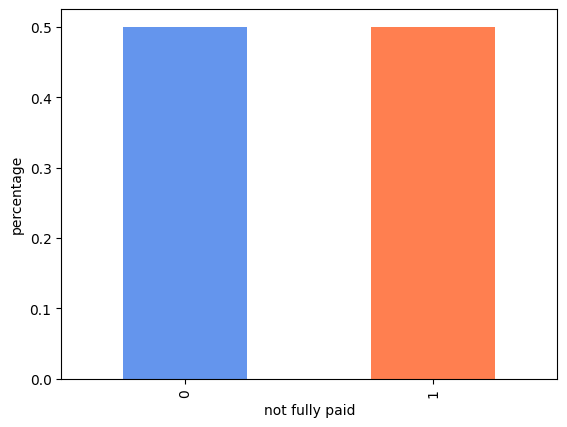

In [24]:
# Let's take a look at the distribution of the target after applying SMOTENC.

# Percentage
y_train_res.value_counts(normalize=True).plot(kind='bar', color=['cornflowerblue', 'coral'])
plt.xlabel('not fully paid')
plt.ylabel('percentage');

## IV. Establish Baseline

In [25]:
 print('Baseline accuracy - imbalanced data:', y_train.value_counts(normalize=True).max())

Baseline accuracy - imbalanced data: 0.8350465002447381


In [26]:
 print('Baseline accuracy - balanced data:', y_train_res.value_counts(normalize=True).max())

Baseline accuracy - balanced data: 0.5


In [27]:
# Model 1 : Logistic Regression - Balanced Data

model_lr_res = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(), 
    StandardScaler(),
    LogisticRegression()
)

model_lr_res.fit(X_train_res, y_train_res);

/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [28]:
# Model 2 : Random Forest - Balanced Data

model_rf_res = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()    # max_depth=35, n_estimators=100, n_jobs= -1
)

model_rf_res.fit(X_train_res, y_train_res);

In [29]:
# Predictions
y_pred_lr_res = model_lr_res.predict(X_val)
y_pred_rf_res = model_rf_res.predict(X_val)

### Accuracy

In [30]:
print('Training Accuracy (LOGR) Balanced Data:', model_lr_res.score(X_train_res, y_train_res))
print('Validation Accuracy (LOGR) Balanced Data:', model_lr_res.score(X_val, y_val))

Training Accuracy (LOGR) Balanced Data: 0.7086752637749121
Validation Accuracy (LOGR) Balanced Data: 0.7064579256360078


In [31]:
print('Training Accuracy (RF) Balanced Data:', model_rf_res.score(X_train_res, y_train_res))
print('Validation Accuracy (RF) Balanced Data:', model_rf_res.score(X_val, y_val))

Training Accuracy (RF) Balanced Data: 1.0
Validation Accuracy (RF) Balanced Data: 0.741030658838878


 💡 Before doing feature engineering, the training accuracy for LOGR was 0.6759, and the validation accuracy for LOGR was 0.6758. After creating new features from the existing data to get more insights about the outcome of the loans, both the training and accuracy score of the LOGR model show some improvements. 
 
The RF model had a training accuracy score of 1.0 and validation accuracy score of 0.7541. As we can see, this model experienced a reduction in the accuracy score for both the validation and training sets. 

### Precision, Recall, F1

Logistic Regression Balanced Data
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1316
           1       0.21      0.40      0.28       217

    accuracy                           0.71      1533
   macro avg       0.55      0.58      0.55      1533
weighted avg       0.79      0.71      0.74      1533



/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


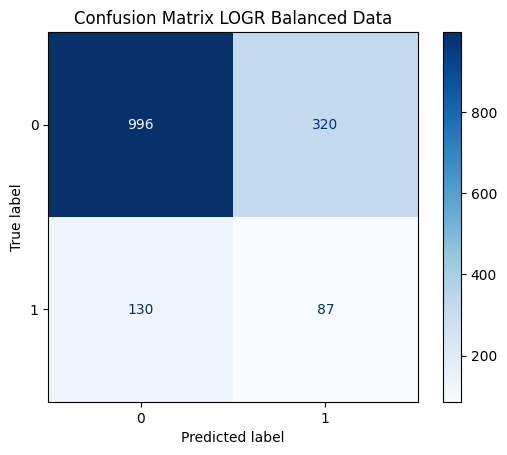

In [32]:
print('Logistic Regression Balanced Data')
print(classification_report(y_val, y_pred_lr_res));
plot_confusion_matrix(model_lr_res, X_val, y_val, cmap=plt.cm.Blues)
plt.title('Confusion Matrix LOGR Balanced Data');

💡 The LOGR predictions about loans that were not fully paid were correct 21% of the times (precision). This model correctly classified 40% of the default loans (recall).

Random Forest Balanced Data


/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1316
           1       0.20      0.27      0.23       217

    accuracy                           0.74      1533
   macro avg       0.54      0.55      0.54      1533
weighted avg       0.78      0.74      0.76      1533



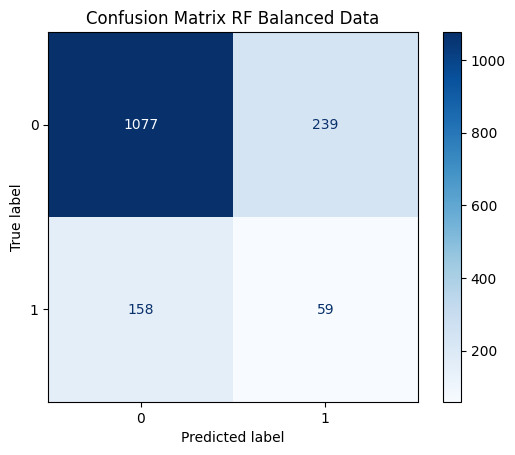

In [33]:
print('Random Forest Balanced Data')
print(classification_report(y_val, y_pred_rf_res));
plot_confusion_matrix(model_rf_res, X_val, y_val, cmap=plt.cm.Blues)
plt.title('Confusion Matrix RF Balanced Data');

💡 The RF model predictions about loans that were not fully paid, were correct 20% of the times (precision). The model correctly classified 28% of the default loans (recall).

/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


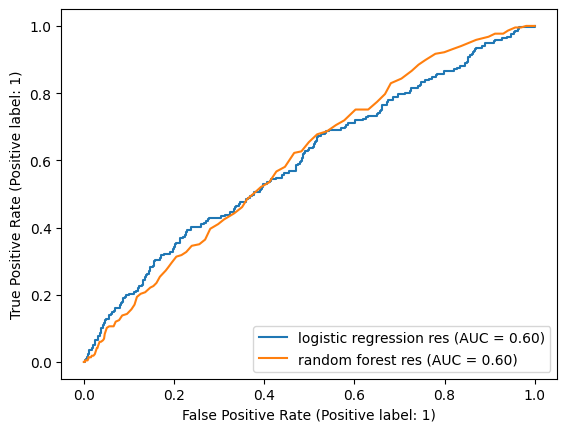

In [34]:
# Plot the ROC Curve

lr_res = plot_roc_curve(
    model_lr_res, 
    X_val,
    y_val,
    name= 'logistic regression res')

rf_res = plot_roc_curve(
    model_rf_res, 
    X_val,
    y_val, 
    ax=lr_res.ax_,
    name= 'random forest res')

In [35]:
print('ROC AUC Score for LOGR balanced data:', roc_auc_score(y_val, model_lr_res.predict_proba(X_val)[:, -1]))
print('ROC AUC Score for RF balanced data:', roc_auc_score(y_val, model_rf_res.predict_proba(X_val)[:, -1]))

ROC AUC Score for LOGR balanced data: 0.5960353255921449
ROC AUC Score for RF balanced data: 0.6023909907133753


💡 The ROC AUC score for both models was very close but higher for the RF model.

💡 The recall was higher for the LOGR model. Since we want to alert investors when borrowers might default on the loans, we are going to prefer higher recall than precision.  

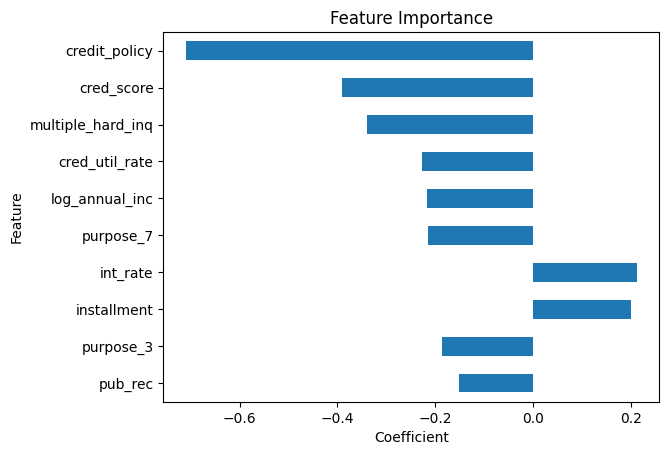

In [36]:
# Plotting feature importances
features = model_lr_res.named_steps['onehotencoder'].get_feature_names()
coefficients = model_lr_res.named_steps['logisticregression'].coef_[0]
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance');

### Hyperparameter Tuning

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1316
           1       0.21      0.40      0.28       217

    accuracy                           0.71      1533
   macro avg       0.55      0.58      0.55      1533
weighted avg       0.79      0.71      0.74      1533



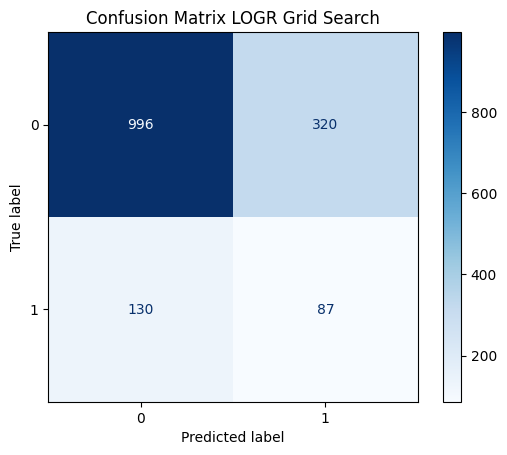

In [37]:
# Grid Search for LOGR Model to Maximize Recall using Val Set

param_grid_lr = {
    'logisticregression__C': np.logspace(0, 5, 10),
    'logisticregression__penalty': ["none", "l2"]
}


lr_gs = GridSearchCV(model_lr_res,
             param_grid=param_grid_lr,
             n_jobs=-1,
             cv=5,
             scoring='recall',
             verbose=1,
             )

lr_gs.fit(X_train_res,y_train_res)


# Predict values based on new parameters
y_predlr_gs = lr_gs.predict(X_val)


# New Model Classification Report 
print(classification_report(y_val, y_predlr_gs));

#Logistic Regression (Grid Search) Confusion matrix
plot_confusion_matrix(lr_gs, X_val, y_val, cmap=plt.cm.Blues)
plt.title('Confusion Matrix LOGR Grid Search');

In [38]:
# Best Parameters in the LOGR model
print('Best Params (LOGR):', lr_gs.best_params_)

Best Params (LOGR): {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2'}


In [39]:
# ROC AUC score
print('ROC AUC Score for LOGR:', roc_auc_score(y_val, lr_gs.predict_proba(X_val)[:, -1]))

ROC AUC Score for LOGR: 0.5960353255921449


Even though we tuned the LOGR model we did not get a recall score better than the initial one.

Fitting 5 folds for each of 90 candidates, totalling 450 fits
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1316
           1       0.20      0.28      0.23       217

    accuracy                           0.74      1533
   macro avg       0.53      0.55      0.54      1533
weighted avg       0.78      0.74      0.76      1533



/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


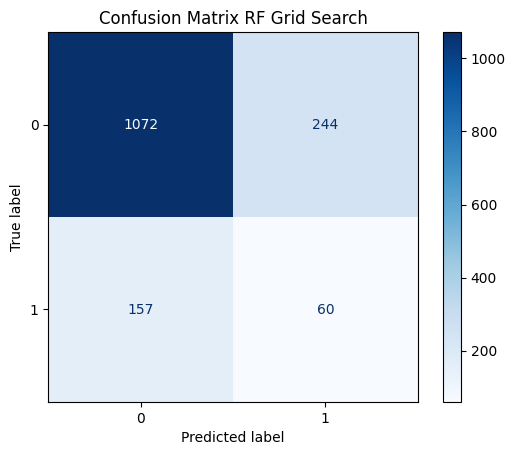

In [42]:
# Grid Search Random Forest to Maximize Recall using Test Set

param_grid_rf = {
    'simpleimputer__strategy': ['most_frequent', 'constant'],
    'randomforestclassifier__max_depth': range(5,50,5),
    'randomforestclassifier__n_estimators': range(25,150,25)
}


rf_gs = GridSearchCV(model_rf_res,
             param_grid=param_grid_rf,
             n_jobs=-1,
             cv=5,
             scoring='recall',
             verbose=1,
             )
rf_gs.fit(X_train_res,y_train_res)


#Predict values based on new parameters
y_predrf_gs = rf_gs.predict(X_val)


# New Model Classification Report 
print(classification_report(y_val, y_predrf_gs));

#Logistic Regression (Grid Search) Confusion matrix
plot_confusion_matrix(rf_gs, X_val, y_val, cmap=plt.cm.Blues)
plt.title('Confusion Matrix RF Grid Search');

After doing some hyperparameter tuning on the RF model, we improved the recall score for one point.

### Predictions using Test Set

The LOGR model got a better recall on the test data than on the validation data. This model correctly classified 44% of the relevant default loans. 

              precision    recall  f1-score   support

           0       0.88      0.76      0.81      1611
           1       0.26      0.44      0.32       305

    accuracy                           0.71      1916
   macro avg       0.57      0.60      0.57      1916
weighted avg       0.78      0.71      0.73      1916

ROC AUC Score for LOGR: 0.6129783964750537


/Users/Yanin/.local/share/virtualenvs/virtualenv-xJnVbN3L/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


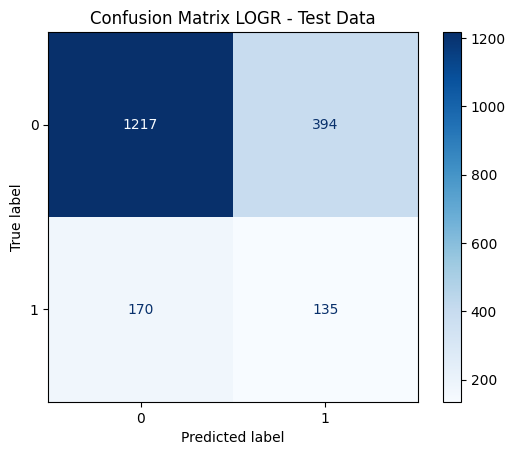

In [43]:
# Predict values
y_predlr_gs_test = lr_gs.predict(X_test)

# Model Classification Report on Test Set
print(classification_report(y_test, y_predlr_gs_test));

# Logistic Regression (Grid Search) Confusion matrix
plot_confusion_matrix(lr_gs, X_test, y_test, cmap=plt.cm.Blues);
plt.title('Confusion Matrix LOGR - Test Data');

# ROC AUC score Test Set
print('ROC AUC Score for LOGR:', roc_auc_score(y_test, lr_gs.predict_proba(X_test)[:, -1]))